In [1]:
pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np 
import itertools
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense  
from tensorflow.keras import applications  
from tensorflow.keras.utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime  
import time 
import PIL
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.models import load_model
%matplotlib inline

In [4]:
print(np.__version__)
print(PIL.__version__)
print(tf.__version__)

1.26.4
10.3.0
2.17.0


In [5]:
import os
print(os.getcwd())

C:\Users\momo-\IMG_PJ\VGG16


In [6]:
# กำหนดขนาดภาพ
img_width, img_height = 224, 224  

# กำหนดเส้นทางสำหรับบันทึกน้ำหนักโมเดล
top_model_weights_path = 'model/art_VGG16_model.weights.h5'  

# สร้างไดเรกทอรีทั้งหมดที่จำเป็น ถ้ายังไม่มีอยู่
os.makedirs(os.path.dirname(top_model_weights_path), exist_ok=True)

# กำหนดเส้นทางไปยังชุดข้อมูล
train_data_dir = r'C:\Users\momo-\Downloads\archive\dataset\dataset_updated\training_set'  
validation_data_dir = r'C:\Users\momo-\Downloads\archive\dataset\dataset_updated\validation_set'  
test_data_dir = r'C:\Users\momo-\Downloads\archive\musemart\dataset_updated\validation_set'

# กำหนดจำนวน epoch และ batch size
epochs = 30 
batch_size = 64 

In [7]:
print(f"Training data directory: {train_data_dir}")
print(f"Validation data directory: {validation_data_dir}")
print(f"Test data directory: {test_data_dir}")

Training data directory: C:\Users\momo-\Downloads\archive\dataset\dataset_updated\training_set
Validation data directory: C:\Users\momo-\Downloads\archive\dataset\dataset_updated\validation_set
Test data directory: C:\Users\momo-\Downloads\archive\musemart\dataset_updated\validation_set


In [8]:
def validate_images(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # ตรวจสอบความถูกต้องของไฟล์
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Invalid image file detected: {file_path}. Removing file.")
                    os.remove(file_path)
            else:
                # ลบไฟล์ที่ไม่ใช่รูปภาพ
                file_path = os.path.join(root, file)
                print(f"Non-image file detected: {file_path}. Removing file.")
                os.remove(file_path)

def convert_images_to_rgb(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        # ตรวจสอบโหมดภาพ
                        if img.mode in ('P', 'RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
                            rgb_img = img.convert('RGB')
                            rgb_img.save(file_path)
                            print(f"Converted {file_path} to RGB")
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Could not convert {file_path}: {e}")
                    # อาจต้องการลบไฟล์ที่ไม่สามารถแปลงได้
                    os.remove(file_path)
            else:
                # ลบไฟล์ที่ไม่ใช่รูปภาพ
                file_path = os.path.join(root, file)
                print(f"Non-image file detected: {file_path}. Removing file.")
                os.remove(file_path)

def detailed_validate_images(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    invalid_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                        img = img.convert('RGB')  # แปลงเป็น RGB เพื่อให้แน่ใจ
                        img.save(file_path)
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Invalid image file detected and removed: {file_path}. Error: {e}")
                    invalid_files.append(file_path)
                    os.remove(file_path)
            else:
                # ลบไฟล์ที่ไม่ใช่รูปภาพ
                file_path = os.path.join(root, file)
                print(f"Non-image file detected and removed: {file_path}")
                os.remove(file_path)
    print(f"Total invalid or non-image files removed: {len(invalid_files)}")

def find_invalid_images(directory):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    invalid_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(valid_extensions):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                except (IOError, SyntaxError, UnidentifiedImageError) as e:
                    print(f"Invalid image file: {file_path}. Error: {e}")
                    invalid_files.append(file_path)
    print(f"Found {len(invalid_files)} invalid images.")
    return invalid_files

def safe_flow_from_directory(directory, **kwargs):
    datagen = ImageDataGenerator(**kwargs)
    generator = datagen.flow_from_directory(directory, **kwargs)
    while True:
        try:
            batch = next(generator)
            yield batch
        except UnidentifiedImageError as e:
            print(f"Skipped an invalid image: {e}")
            continue
        except StopIteration:
            break

In [9]:
# โหลดโมเดล VGG16 โดยไม่รวมชั้นการจำแนกประเภท
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 
datagen = ImageDataGenerator(rescale=1. / 255)  

In [28]:
# เริ่มต้นจับเวลา
start = datetime.datetime.now()

# สร้าง generator สำหรับการฝึก
generator_train = datagen.flow_from_directory(  
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    color_mode='rgb')  

nb_train_samples = len(generator_train.filenames)  
num_classes = len(generator_train.class_indices)  

predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

# สร้าง bottleneck features สำหรับการฝึก
bottleneck_features_train = vgg16.predict(generator_train, steps=predict_size_train, verbose=1)  

# บันทึกฟีเจอร์ที่สร้างขึ้น
np.save('model/bottleneck_features_train.npy', bottleneck_features_train)

# จบจับเวลา
end = datetime.datetime.now()
elapsed = end - start
print('Time for training bottleneck features:', elapsed) 

Found 7721 images belonging to 5 classes.
121/121 ━━━━━━━━━━━━━━━━━━━━ 1836s 15s/step
Time for training bottleneck features: 0:30:39.826244


In [29]:
print('-'*150)

------------------------------------------------------------------------------------------------------------------------------------------------------


In [30]:
# เริ่มต้นจับเวลาใหม่สำหรับ validation
start = datetime.datetime.now()

# สร้าง generator สำหรับ validation
generator_val = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False,
    color_mode='rgb'
)

nb_validation_samples = len(generator_val.filenames)
print(f"Number of validation samples: {nb_validation_samples}")

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

# สร้าง bottleneck features สำหรับ validation
bottleneck_features_validation = vgg16.predict(
    generator_val,
    steps=predict_size_validation,
    verbose=1
)
np.save('model/bottleneck_features_validation.npy', bottleneck_features_validation)

# จบจับเวลา
end = datetime.datetime.now()
elapsed = end - start
print('Time for validation bottleneck features:', elapsed)

Found 856 images belonging to 5 classes.
Number of validation samples: 856
14/14 ━━━━━━━━━━━━━━━━━━━━ 202s 14s/step
Time for validation bottleneck features: 0:03:23.365764


In [31]:
print('-'*150)

------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
# เริ่มต้นจับเวลาใหม่สำหรับ test
start = datetime.datetime.now()

# สร้าง generator สำหรับ test
generator_test = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # เปลี่ยนเป็น 'categorical' เพื่อให้ได้ labels
    shuffle=False,
    color_mode='rgb'
)

# Count number of test samples
nb_test_samples = len(generator_test.filenames)
print(f"Number of test samples: {nb_test_samples}")

predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# Generate bottleneck features for test
try:
    bottleneck_features_test = vgg16.predict(generator_test, steps=predict_size_test, verbose=1)
    np.save('model/bottleneck_features_test.npy', bottleneck_features_test)
except UnidentifiedImageError as e:
    print(f"Error during test bottleneck features generation: {e}")
    # คุณสามารถเพิ่มโค้ดเพิ่มเติมที่นี่เพื่อจัดการกับข้อผิดพลาด

# จบจับเวลา
end = datetime.datetime.now()
elapsed = end - start
print('Time for test bottleneck features:', elapsed)

Found 265 images belonging to 5 classes.
Number of test samples: 265
5/5 ━━━━━━━━━━━━━━━━━━━━ 65s 12s/step
Time for test bottleneck features: 0:01:05.921906


In [33]:
print('-'*150)

------------------------------------------------------------------------------------------------------------------------------------------------------


In [34]:
train_data = np.load('model/bottleneck_features_train.npy')
train_labels = to_categorical(generator_train.classes, num_classes=num_classes)


In [35]:
validation_data = np.load('model/bottleneck_features_validation.npy')
validation_labels = to_categorical(generator_val.classes, num_classes=num_classes)


In [43]:
import datetime
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Input
from keras import optimizers
from keras.layers import LeakyReLU

# เริ่มต้นจับเวลา
start = datetime.datetime.now()

# ตรวจสอบขนาดของข้อมูล
print("train_data shape:", train_data.shape)  
print("train_labels shape:", train_labels.shape)  
# ตรวจสอบจำนวนตัวอย่างที่ไม่ซ้ำใน labels
unique_labels = np.unique(train_labels)
print("Unique labels:", unique_labels)

# หากจำนวนตัวอย่างไม่ตรงกัน ให้ปรับปรุง labels ชั่วคราว (ตรวจสอบให้แน่ใจว่าไม่ส่งผลต่อข้อมูลที่สำคัญ)
if train_data.shape[0] != train_labels.shape[0]:
    print("Adjusting train_labels to match train_data...")
    train_labels = train_labels[:train_data.shape[0]]

# สร้างโมเดล
model = Sequential()
model.add(Input(shape=train_data.shape[1:]))  # ใช้ Input แทน Flatten
model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU(negative_slope=0.3))  # เปลี่ยน alpha เป็น negative_slope
model.add(Dropout(0.5))  
model.add(Dense(50))
model.add(LeakyReLU(negative_slope=0.3))  # เปลี่ยน alpha เป็น negative_slope
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

# คอมไพล์โมเดล
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)  

# ฝึกโมเดล
history = model.fit(
    train_data, 
    train_labels,  
    epochs=7,
    batch_size=batch_size,  
    validation_data=(validation_data, validation_labels)
)  

# บันทุนน้ำหนักโมเดล
model.save_weights(top_model_weights_path)  

# ประเมินโมเดล
eval_loss, eval_accuracy = model.evaluate(
    validation_data, 
    validation_labels, 
    batch_size=batch_size, 
    verbose=1
)

# แสดงผลลัพธ์
print("[INFO] Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

# จบการจับเวลา
end = datetime.datetime.now()
elapsed = end - start
print('Time Elapsed:', elapsed)  


train_data shape: (7721, 7, 7, 512)
train_labels shape: (7721, 5)
Unique labels: [0. 1.]
Epoch 1/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6333 - loss: 0.9757 - val_accuracy: 0.8353 - val_loss: 0.4397
Epoch 2/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8435 - loss: 0.4409 - val_accuracy: 0.8773 - val_loss: 0.3483
Epoch 3/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8749 - loss: 0.3489 - val_accuracy: 0.8762 - val_loss: 0.3507
Epoch 4/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8896 - loss: 0.3014 - val_accuracy: 0.8785 - val_loss: 0.3339
Epoch 5/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9063 - loss: 0.2623 - val_accuracy: 0.8668 - val_loss: 0.3489
Epoch 6/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9072 - loss: 0.2436 - val_accuracy: 0.8808 - val_loss: 0.3328
Epoch 7/7
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9224 - loss: 0.2099 - val_accuracy: 0.8890 - val_loss: 0.3036
14/14 ━━━━━━━━

In [44]:
#Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,028,412 (19.18 MB)

 Trainable params: 2,514,205 (9.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,514,207 (9.59 MB)

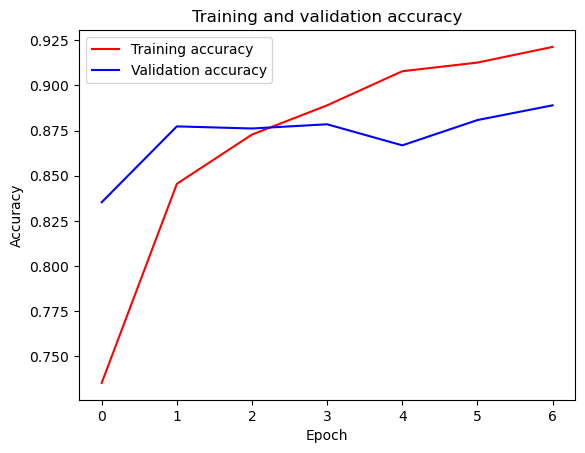

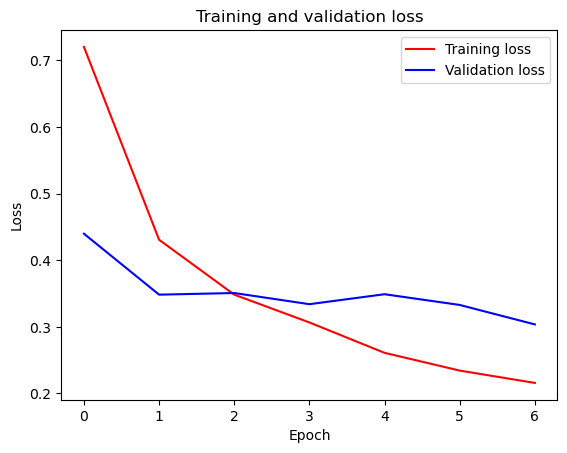

In [45]:
# การวาดกราฟการฝึก
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'r', label='Training accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')
plt.legend()
plt.figure()
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')  
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [46]:
# Ensure that you load bottleneck features for the test set
# Assuming you already have 'bottleneck_features_test.npy' generated
test_data = np.load('model/bottleneck_features_test.npy')

# Convert test labels to categorical
test_labels = to_categorical(generator_test.classes, num_classes=num_classes)

# Now you can evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)
print("[INFO] Test Accuracy: {:.2f}%".format(test_accuracy * 100))  
print("[INFO] Test Loss: {}".format(test_loss))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9637 - loss: 0.1419
[INFO] Test Accuracy: 96.60%
[INFO] Test Loss: 0.12223205715417862


In [47]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[1.81268021e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.99769759e-01 0.00000000e+00]
   [2.33654439e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.97450244e-01 0.00000000e+00]
   [1.91277385e-01 0.00000000e+00 1.05567001e-01 ... 0.00000000e+00
    7.47708559e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.09953487e-01 0.00000000e+00]
   [3.55024785e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.16530848e-01 0.00000000e+00]
   [2.45001242e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    9.12063301e-01 0.00000000e+00]]

  [[5.89774847e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.39499044e-01 0.00000000e+00]
   [5.82945704e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.00525677e+00 0.00000000e+00]
   [3.35556805e-01 0.00000000e+00 7.44714677e-01 ... 0.00000000e+00
    5.84108293e-01 0.00000000e+00]
   ...
   [1.45159876e-02 0.00000000e+00 1.58002484e+0

In [78]:
# Generate classification report
art = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
classification_metrics = classification_report(
    categorical_test_labels, 
    categorical_preds, 
    target_names=art,
    zero_division=0
)
print(classification_metrics)


              precision    recall  f1-score   support

    drawings       0.70      0.94      0.80        17
   engraving       0.96      0.89      0.92        27
 iconography       1.00      1.00      1.00        75
    painting       0.99      0.98      0.98        95
   sculpture       1.00      0.94      0.97        51

    accuracy                           0.97       265
   macro avg       0.93      0.95      0.94       265
weighted avg       0.97      0.97      0.97       265



In [80]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [82]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


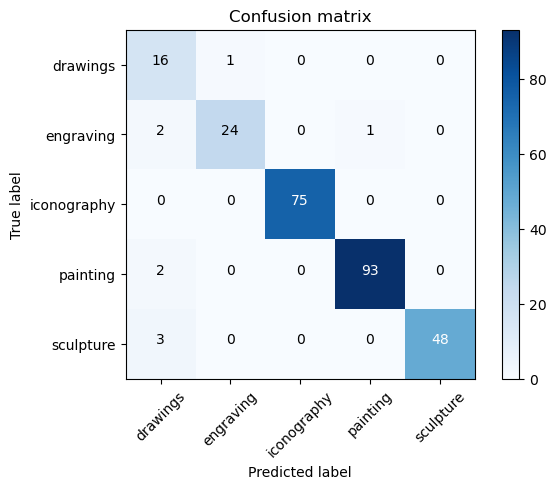

In [84]:
    plot_confusion_matrix(confusion_matrix, ['drawings', 'engraving', 'iconography', 'painting', 'sculpture'])

<Figure size 1000x700 with 0 Axes>

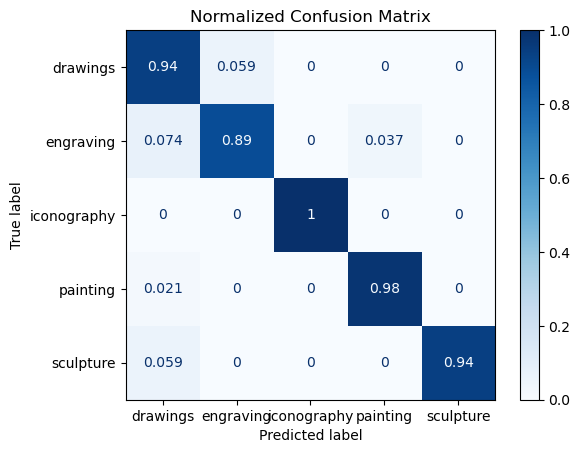

In [86]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert one-hot encoded labels back to class labels
test_labels_flat = np.argmax(test_labels, axis=1)
preds_flat = np.argmax(preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels_flat, preds_flat, labels=[0, 1, 2, 3, 4])

# Normalize the confusion matrix
def normalize_cm(cm):
    with np.errstate(divide='ignore', invalid='ignore'):
        normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    normalized_cm[np.isnan(normalized_cm)] = 0
    return normalized_cm

normalized_cm = normalize_cm(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay(normalized_cm, display_labels=['drawings', 'engraving', 'iconography', 'painting', 'sculpture']).plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()


[INFO] กำลังโหลดและเตรียมภาพ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
ID: 0, Label: drawings, ความมั่นใจ: 31.49%
ID: 1, Label: engraving, ความมั่นใจ: 0.75%
ID: 2, Label: iconography, ความมั่นใจ: 7.77%
ID: 3, Label: painting, ความมั่นใจ: 54.29%
ID: 4, Label: sculpture, ความมั่นใจ: 5.7%
Final Decision:
.
..
...
ID: 3, Label: painting


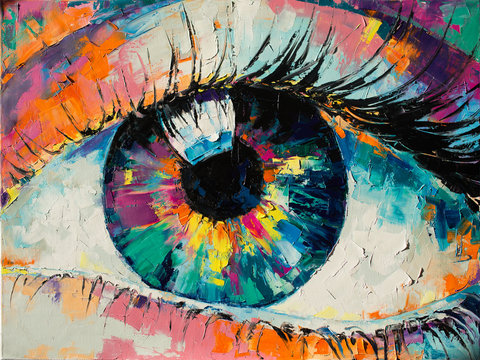

In [88]:
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ฟังก์ชันสำหรับอ่านและเตรียมภาพเดี่ยว
def read_image(file_path):
    print("[INFO] กำลังโหลดและเตรียมภาพ...")
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

def test_single_image(path):
    art = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
    images = read_image(path)
    time.sleep(0.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)

    for idx, label, x in zip(range(len(art)), art, preds[0]):
        print(f"ID: {idx}, Label: {label}, ความมั่นใจ: {round(x * 100, 2)}%")

    print('Final Decision:')
    time.sleep(0.5)
    for x in range(3):
        print('.' * (x + 1))
        time.sleep(0.2)
    
    # Using a predefined class dictionary
    class_dictionary = {
        0: 'drawings',
        1: 'engraving',
        2: 'iconography',
        3: 'painting',
        4: 'sculpture'
    }

    # Get the predicted class
    class_predicted = np.argmax(preds, axis=1)  # Get the index of the max probability
    print("ID: {}, Label: {}".format(class_predicted[0], class_dictionary[class_predicted[0]]))  
    return load_img(path)

# Example path (make sure to update this with your actual image path)
path = r'C:\Users\momo-\IMG_PJ\testPic.jpg'
test_single_image(path)
